In [ ]:
#This block is for me to run in Google colab
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0,"/content/drive/My Drive/Research/Coherent One Shot Hamiltonian Simulation")

!pip install cirq

In [2]:
# Import packages
from qsp_models import *  # Make sure that qsp_models is in your directory
import tensorflow as tf
import numpy as np

# visualization tools
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import scipy
import IPython
from scipy.special import lambertw
from scipy.optimize import fsolve
from keras import backend as K

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
def r(tau, epsilon):
  r_val = tau*np.exp(lambertw(np.log(1/epsilon)/tau))
  return np.real(r_val)


def gamma(epsilon, Delta):
  val1 = np.exp(1)/Delta*np.sqrt(lambertw(8/(np.pi*epsilon))*lambertw(512/(np.exp(2)*np.pi*epsilon**2)))
  val2 = 1/np.sqrt(2)*lambertw(32/(np.sqrt(np.pi)*Delta*epsilon)*np.sqrt(lambertw(8/(np.pi*epsilon))))
  val3 = 2*np.ceil(max(np.real(val1), np.real(val2)))+1
  return val3  


def N_0(epsilon, t, alpha):
  val1 = 1/2*r(np.exp(1)/2*alpha*np.abs(t), 5*epsilon/16)
  val2 = 4*np.floor(val1) + 1
  return val2


def N_Amp(epsilon, delta, t, alpha):
  val1 = gamma(delta/2, 1-epsilon)*N_0(epsilon, t, alpha)
  return val1


def N_Co(epsilon, beta, t, alpha):
  val1 = 1/2*r(np.exp(2)*alpha*np.abs(t)/(2*beta), 5*epsilon/24)
  val2 = 2*np.floor(val1) + gamma(epsilon/3, 1-beta) + 1
  return val2


def mean_deviation(y_true, y_pred):
  deviations = tf.abs(tf.subtract(y_true, y_pred))
  loss = tf.math.reduce_mean(deviations)
  return loss


def max_deviation(y_true, y_pred):
  deviations = tf.abs(tf.subtract(y_true, y_pred))
  loss = tf.math.reduce_max(deviations)
  return loss


def mean_deviation_squared(y_true, y_pred):
  deviations = tf.abs(tf.subtract(y_true, y_pred))
  loss = tf.math.reduce_mean(tf.square(deviations))
  return loss


def max_deviation_squared(y_true, y_pred):
  deviations = tf.abs(tf.subtract(y_true, y_pred))
  loss = tf.math.reduce_max(tf.square(deviations))
  return loss

We will simulate the Hamiltonian
$$ H = H_0 + H_1 $$
where
$$ 
\begin{align}
  H_0 &= \sum_{j = 1}^n h_j \sigma_j^z \\
  H_1 &= \sum_{j = 1}^n ( g_j^x \sigma_j^x \sigma_{j+1}^x + g_j^y \sigma_j^y \sigma_{j+1}^y + g_j^z \sigma_j^z \sigma_{j+1}^z )
\end{align}
$$

For simplicty, we will assume $n=2$ spins. In this case, we can diagonalize $H$, and determine a sufficient $\alpha \geq \|H\|$, given by the expression in the code block below.

In [4]:
#Hamiltonian Properties

h1 = 0
h2 =0
gx = 1
gy = 0
gz = 0

eigenvals = np.array([-gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5, 
                      -gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5])
alpha = max(np.abs(eigenvals))

## **Finding Phase Angles for Approximation to Complex Exponential**

Epoch 1/2400
5/5 - 14s - loss: 2.3657
Epoch 2/2400
5/5 - 0s - loss: 2.1891
Epoch 3/2400
5/5 - 0s - loss: 2.1187
Epoch 4/2400
5/5 - 0s - loss: 1.9521
Epoch 5/2400
5/5 - 0s - loss: 1.8857
Epoch 6/2400
5/5 - 0s - loss: 1.7862
Epoch 7/2400
5/5 - 0s - loss: 1.6789
Epoch 8/2400
5/5 - 0s - loss: 1.6106
Epoch 9/2400
5/5 - 0s - loss: 1.5394
Epoch 10/2400
5/5 - 0s - loss: 1.4533
Epoch 11/2400
5/5 - 0s - loss: 1.4015
Epoch 12/2400
5/5 - 0s - loss: 1.3074
Epoch 13/2400
5/5 - 0s - loss: 1.2828
Epoch 14/2400
5/5 - 0s - loss: 1.2023
Epoch 15/2400
5/5 - 0s - loss: 1.1261
Epoch 16/2400
5/5 - 0s - loss: 1.0695
Epoch 17/2400
5/5 - 0s - loss: 1.0074
Epoch 18/2400
5/5 - 0s - loss: 0.9604
Epoch 19/2400
5/5 - 0s - loss: 0.9063
Epoch 20/2400
5/5 - 0s - loss: 0.8584
Epoch 21/2400
5/5 - 0s - loss: 0.8026
Epoch 22/2400
5/5 - 0s - loss: 0.7503
Epoch 23/2400
5/5 - 0s - loss: 0.7081
Epoch 24/2400
5/5 - 0s - loss: 0.6670
Epoch 25/2400
5/5 - 0s - loss: 0.6295
Epoch 26/2400
5/5 - 0s - loss: 0.5898
Epoch 27/2400
5/5 - 

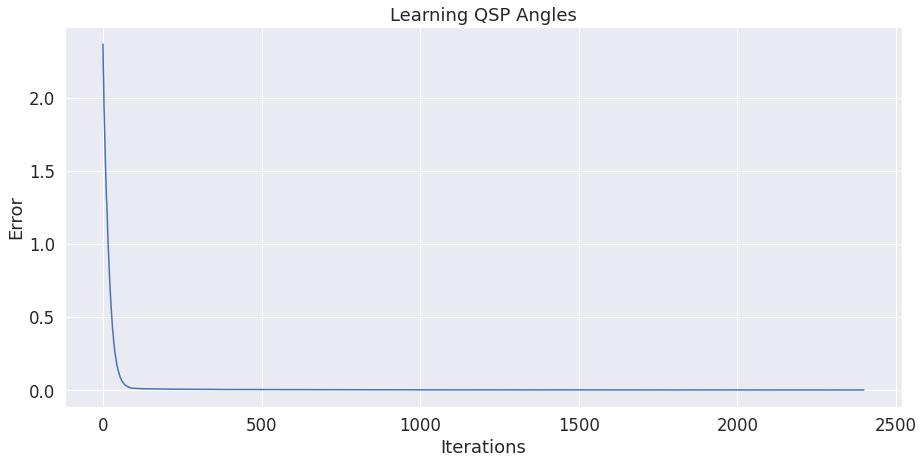

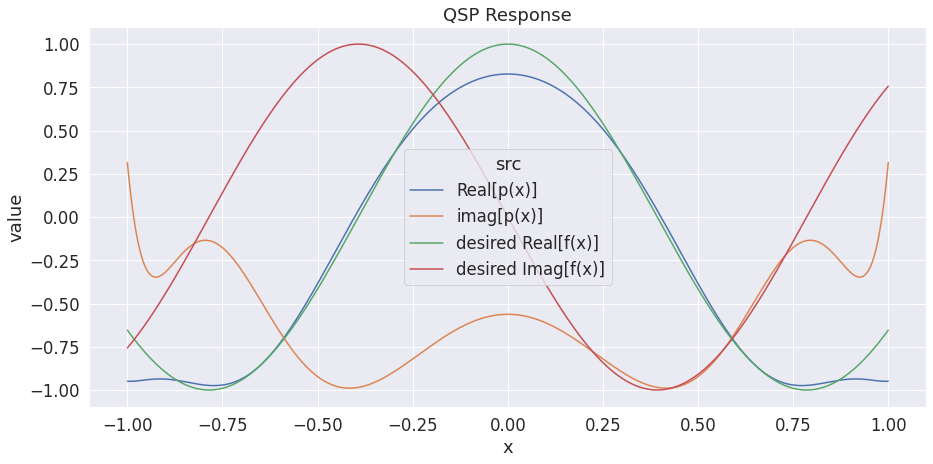

Epoch 1/350
1/1 - 9s - loss: 0.0017
Epoch 2/350
1/1 - 0s - loss: 0.0017
Epoch 3/350
1/1 - 0s - loss: 0.0017
Epoch 4/350
1/1 - 0s - loss: 0.0016
Epoch 5/350
1/1 - 0s - loss: 0.0016
Epoch 6/350
1/1 - 0s - loss: 0.0016
Epoch 7/350
1/1 - 0s - loss: 0.0017
Epoch 8/350
1/1 - 0s - loss: 0.0017
Epoch 9/350
1/1 - 0s - loss: 0.0017
Epoch 10/350
1/1 - 0s - loss: 0.0017
Epoch 11/350
1/1 - 0s - loss: 0.0016
Epoch 12/350
1/1 - 0s - loss: 0.0016
Epoch 13/350
1/1 - 0s - loss: 0.0016
Epoch 14/350
1/1 - 0s - loss: 0.0016
Epoch 15/350
1/1 - 0s - loss: 0.0016
Epoch 16/350
1/1 - 0s - loss: 0.0016
Epoch 17/350
1/1 - 0s - loss: 0.0016
Epoch 18/350
1/1 - 0s - loss: 0.0016
Epoch 19/350
1/1 - 0s - loss: 0.0016
Epoch 20/350
1/1 - 0s - loss: 0.0016
Epoch 21/350
1/1 - 0s - loss: 0.0016
Epoch 22/350
1/1 - 0s - loss: 0.0016
Epoch 23/350
1/1 - 0s - loss: 0.0016
Epoch 24/350
1/1 - 0s - loss: 0.0016
Epoch 25/350
1/1 - 0s - loss: 0.0016
Epoch 26/350
1/1 - 0s - loss: 0.0016
Epoch 27/350
1/1 - 0s - loss: 0.0016
Epoch 28/3

In [6]:
# Simulation setup
t = 1.0
beta = 0.5   
tau = 2*t*alpha/beta

# Polynomial setup
poly_deg = 12
f_real = lambda x: np.cos(tau * x)
f_imag = lambda x: -1*np.sin(tau *x)

# QSP convention and learning rate
convention = 0      #|0><0| convention
learning_rate = 0.002

# Define loss function as maximum squred error
mean_or_max = 1     # 0=mean, 1=max
squared = 1         # 0=|y_pred-y_true|, 1=|y_pred-y_true|^2

# The intput theta training values 
th_in = np.linspace(np.arccos((1+beta)/2), np.arccos((1-beta)/2), 500)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# We desire p(x) to be f(x)
expected_outputs = (f_real(np.cos(th_in))[:,0] +1j*f_imag(np.cos(th_in))[:,0]).astype('complex64')

# Train the model
model = construct_qsp_model(poly_deg, convention, learning_rate, mean_or_max, squared)
history = model.fit(x=th_in, y=expected_outputs, batch_size=100, epochs=2400, verbose=2)
plot_loss(history)
plot_qsp_response(f_real, f_imag, model, convention)

# Additional training steps at smaller learning rate
K.set_value(model.optimizer.learning_rate, 0.0005)
history = model.fit(x=th_in, y=expected_outputs, batch_size = 500, epochs=350, verbose=2)
K.set_value(model.optimizer.learning_rate, 0.00001)
history = model.fit(x=th_in, y=expected_outputs, batch_size = 500, epochs=350, verbose=2)

In [7]:
# Calculate error and query complexities
th_in2 = np.linspace(np.arccos((1+beta)/2), np.arccos((1-beta)/2), int(1e4))
th_in2 = tf.reshape(th_in2, (th_in2.shape[0], 1))
expected_outputs2 = (f_real(np.cos(th_in2))[:,0] +1j*f_imag(np.cos(th_in2))[:,0]).astype('complex64')

error = max_deviation(model(th_in2), expected_outputs2).numpy()
print(str(error) +'\n')
print(N_Amp(error, 2*error, t, alpha))
print(N_Co(error, beta, t, alpha))
print(poly_deg)

0.039084673

261.0
80.0
12


In [8]:
#Output QSP phases
phis = model.trainable_weights[0].numpy()
for phi in phis:
  print(phi[0])

1.8397211
2.125738
1.3671367
2.8627694
2.4593945
0.63814545
0.74940425
0.77885324
2.4058354
0.49949756
2.3049574
1.0903457
2.5526578
